##### Copyright 2022 nostalgic \<scorpion@dgu.ac.kr\> Authors.

In [1]:
'''
Author: nostalgic<scorpion@dgu.ac.kr>
Apache License, Version 2.0 (the "License");
''' 

'\nAuthor: nostalgic<scorpion@dgu.ac.kr>\nApache License, Version 2.0 (the "License");\n'

# Release Note

|날짜|작성자|버전|
|----------|------|------|
|2022.06.25|박재용|v1.0.0|

## Import Libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
hallo = tf.constant('why?' )
print(hallo)

tf.Tensor(b'why?', shape=(), dtype=string)


## 데이터 디렉터리 구조

### v1.0.0

```data
   train/
      normal/
      abnormal/
      ```

In [3]:
import pathlib
dataset_url = "./data/integrate-hsv"
data_dir = pathlib.Path(dataset_url)

## 파라미터 정의


In [4]:
batch_size = 32
img_height = 512
img_width = 512

#### training data : 80%

In [5]:

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir, #".\\data\\train",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(768, 768),
  batch_size=batch_size)

Found 776 files belonging to 2 classes.
Using 621 files for training.


#### validation data : 20%

In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(768, 768),
  batch_size=batch_size)

Found 776 files belonging to 2 classes.
Using 155 files for validation.


#### 레이블 확인 

In [7]:
class_names = train_ds.class_names
print(class_names)

['NORMAL', 'STENOSIS']


## 데이터 확인
일부 트레이닝 데이터의 시각적 확인

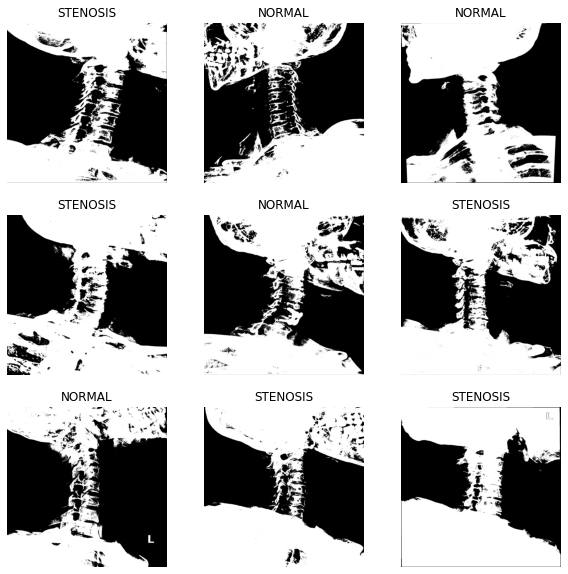

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
for image_batch, labels_batch in train_ds:
  print("Batch, SizeW, SizeH, RGB",image_batch.shape)
  print("Image Label",labels_batch.shape)
  break

Batch, SizeW, SizeH, RGB (32, 768, 768, 3)
Image Label (32,)


In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 데이터 정규화

In [11]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [12]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


# 모델 구성

### Augmentation

In [13]:
data_augmentation = keras.Sequential(
  [
    
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(768, 
                                                              768,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.CenterCrop(img_height,img_width),
  ]
)

#### Augmentation Result

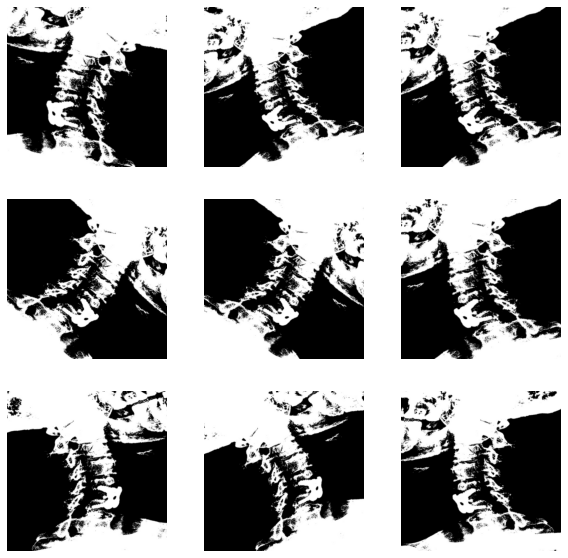

In [14]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Dropout

In [15]:
num_classes=5
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## 모델 컴파일

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
20/20 [==============================] - 11s 544ms/step - loss: 0.7343 - accuracy: 0.5878 - val_loss: 0.6900 - val_accuracy: 0.6323
Epoch 2/20
20/20 [==============================] - 9s 453ms/step - loss: 0.6586 - accuracy: 0.6473 - val_loss: 0.6745 - val_accuracy: 0.6323
Epoch 3/20
20/20 [==============================] - 9s 456ms/step - loss: 0.6644 - accuracy: 0.6296 - val_loss: 0.6770 - val_accuracy: 0.6323
Epoch 4/20
20/20 [==============================] - 9s 457ms/step - loss: 0.6513 - accuracy: 0.6522 - val_loss: 0.6796 - val_accuracy: 0.6323
Epoch 5/20
20/20 [==============================] - 9s 453ms/step - loss: 0.6585 - accuracy: 0.6473 - val_loss: 0.6730 - val_accuracy: 0.6258
Epoch 6/20
20/20 [==============================] - 9s 451ms/step - loss: 0.6394 - accuracy: 0.6618 - val_loss: 0.7235 - val_accuracy: 0.6258
Epoch 7/20
20/20 [==============================] - 9s 450ms/step - loss: 0.6379 - accuracy: 0.6554 - val_loss: 0.6864 - val_accuracy: 0.6323
Epoch

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 512, 512, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 512, 512, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 512, 512, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 256, 256, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                  

## 결과 시각화

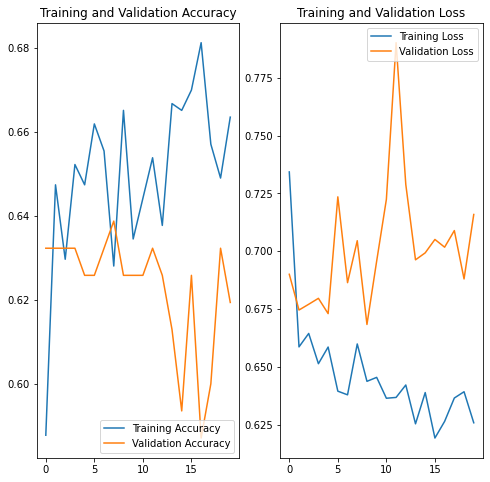

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()